

Лабораторная работа 2.

Выполнил: Очередько А.Н.

Группа: ББМО-01-23


Реализация задания:

In [1]:
import kagglehub

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Путь к датасету в среде Google Colab:", path)


100%|██████████| 612M/612M [00:27<00:00, 23.0MB/s]

Extracting files...


Путь к датасету в среде Google Colab: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [2]:
!mv /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/ /content/gtsrb

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")


Используемое устройство: cuda


In [4]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Функция для загрузки и подготовки данных GTSRB
def prepare_gtsrb_dataset(directory_path):
    images_data = []
    labels_data = []
    for label in range(43):
        class_folder = os.path.join(directory_path, str(label))
        if not os.path.exists(class_folder):
            print(f"Папка {class_folder} не найдена, пропускаем...")
            continue
        for image_file in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(32, 32))
            image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
            images_data.append(image_array)
            labels_data.append(label)
    return np.array(images_data), np.array(labels_data)

data_directory = "/content/gtsrb/1/train"

# Загрузка данных GTSRB
images_data, labels_data = prepare_gtsrb_dataset(data_directory)

# Разделение данных на обучающую, валидационную и тестовую выборки
X_train, X_remaining, y_train, y_remaining = train_test_split(images_data, labels_data, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Преобразование меток классов в формат one-hot
y_train_one_hot = to_categorical(y_train, num_classes=43)
y_val_one_hot = to_categorical(y_val, num_classes=43)
y_test_one_hot = to_categorical(y_test, num_classes=43)

print(f"Размеры наборов данных: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")


Размеры наборов данных: X_train=(27446, 32, 32, 3), X_val=(5881, 32, 32, 3), X_test=(5882, 32, 32, 3)


In [5]:
# Ограничим обучающую выборку до 5000 примеров для ускорения процесса
limited_X_train = X_train[:5000]
limited_y_train = y_train[:5000]

from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model, layers, optimizers

# Инициализация модели VGG16 без верхней части и с предобученными весами
vgg_base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
feature_layer = layers.Flatten()(vgg_base_model.output)
dense_layer = layers.Dense(128, activation="relu")(feature_layer)
output_layer = layers.Dense(43, activation="softmax")(dense_layer)

# Создание полной модели
vgg_model = Model(inputs=vgg_base_model.input, outputs=output_layer)

# Компиляция модели с оптимизатором Adam
vgg_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Преобразование меток в формат one-hot
limited_y_train_one_hot = to_categorical(limited_y_train, num_classes=43)
y_val_one_hot = to_categorical(y_val, num_classes=43)

# Обучение модели
vgg_training_history = vgg_model.fit(
    limited_X_train, limited_y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=5,
    batch_size=32
)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.0586 - loss: 3.8021 - val_accuracy: 0.0576 - val_loss: 3.5605
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.1072 - loss: 3.2877 - val_accuracy: 0.1416 - val_loss: 2.9717
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.1643 - loss: 2.7967 - val_accuracy: 0.1794 - val_loss: 2.5893
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.2236 - loss: 2.4364 - val_accuracy: 0.2852 - val_loss: 2.0492
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3783 - loss: 1.8469 - val_accuracy: 0.4494 - val_loss: 1.6016


In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, optimizers, Model

# Ограничим обучающую выборку до 5000 примеров для ускорения процесса
small_X_train = X_train[:5000]
small_y_train = y_train[:5000]

# Преобразование меток в формат one-hot
small_y_train_one_hot = to_categorical(small_y_train, num_classes=43)
y_val_one_hot = to_categorical(y_val, num_classes=43)

# Инициализация модели ResNet50 без верхней части и с предобученными весами
resnet_base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
flatten_layer = layers.Flatten()(resnet_base_model.output)
dense_layer = layers.Dense(128, activation="relu")(flatten_layer)
output_layer = layers.Dense(43, activation="softmax")(dense_layer)

# Создание полной модели
resnet_model = Model(inputs=resnet_base_model.input, outputs=output_layer)

# Компиляция модели с оптимизатором Adam
resnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Обучение модели
resnet_training_history = resnet_model.fit(
    small_X_train, small_y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=5,
    batch_size=32
)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 106s 260ms/step - accuracy: 0.2836 - loss: 2.9329 - val_accuracy: 0.0211 - val_loss: 4.0281
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6097 - loss: 1.3218 - val_accuracy: 0.0636 - val_loss: 4.4884
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.6914 - loss: 1.0789 - val_accuracy: 0.0558 - val_loss: 32.9874
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6867 - loss: 1.1113 - val_accuracy: 0.4326 - val_loss: 2.2008
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8404 - loss: 0.5489 - val_accuracy: 0.6366 - val_loss: 1.3630


VGG16 - Тестовая точность: 0.45, Тестовая потеря: 1.60
ResNet50 - Тестовая точность: 0.63, Тестовая потеря: 1.40


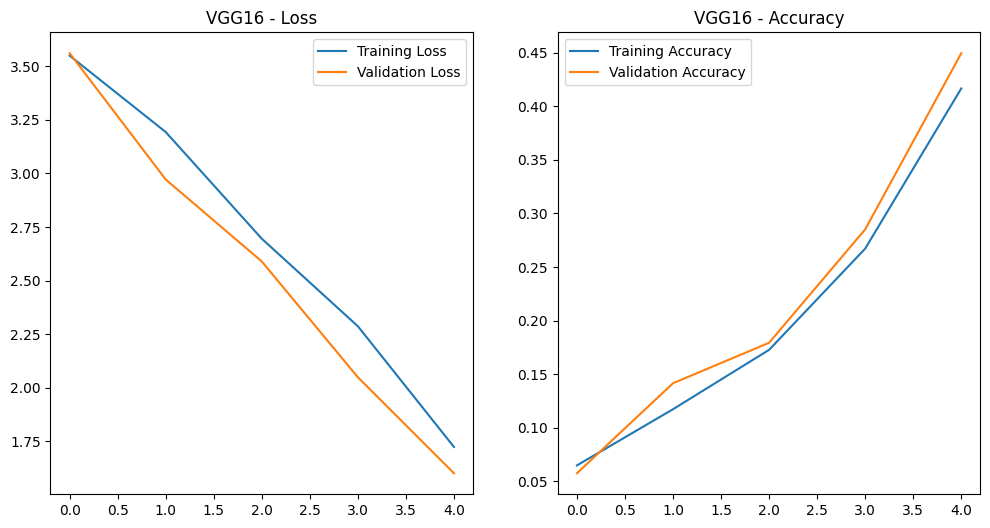

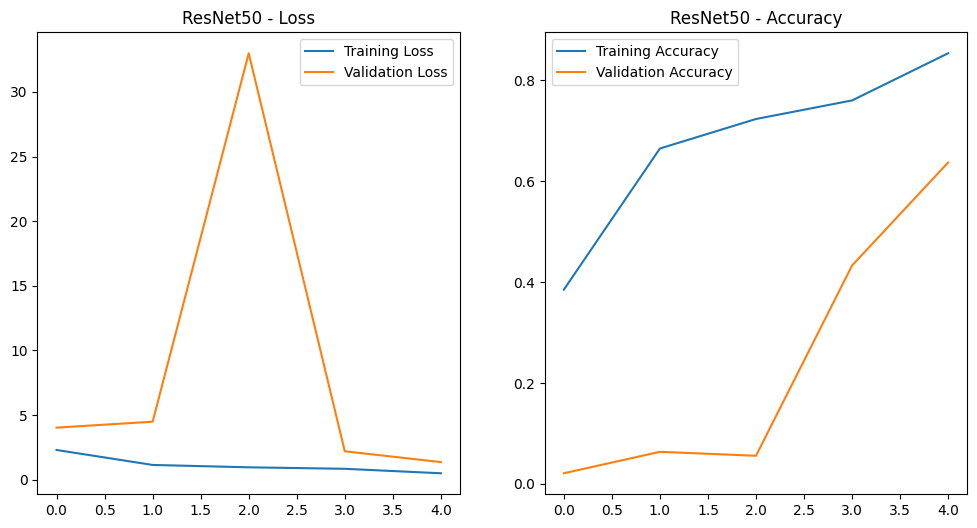

In [10]:
# Оценка моделей
vgg_eval = vgg_model.evaluate(X_test, y_test_one_hot, verbose=0)
resnet_eval = resnet_model.evaluate(X_test, y_test_one_hot, verbose=0)

print(f"VGG16 - Тестовая точность: {vgg_eval[1]:.2f}, Тестовая потеря: {vgg_eval[0]:.2f}")
print(f"ResNet50 - Тестовая точность: {resnet_eval[1]:.2f}, Тестовая потеря: {resnet_eval[0]:.2f}")

# Построение графиков функции потерь и точности
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    plt.show()

# Построение графиков для обеих моделей
plot_history(vgg_training_history, "VGG16")
plot_history(resnet_training_history, "ResNet50")


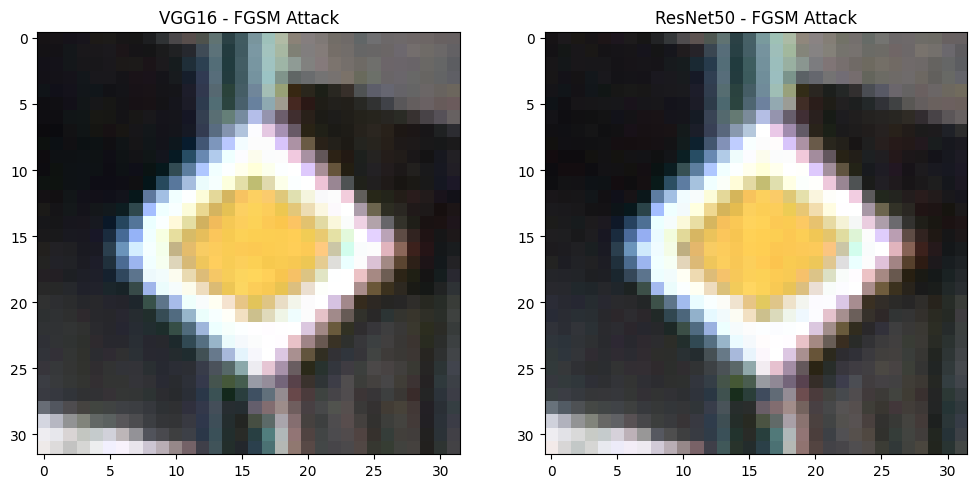

In [11]:
def fgsm_attack(model, image, label, epsilon=0.01):
    image = tf.convert_to_tensor([image], dtype=tf.float32)
    label = tf.convert_to_tensor([label], dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)

    gradient = tape.gradient(loss, image)
    perturbation = epsilon * tf.sign(gradient)
    adversarial_image = tf.clip_by_value(image + perturbation, 0, 1)
    return adversarial_image[0]

# Пример атаки на одно изображение
adv_image_vgg = fgsm_attack(vgg_model, X_test[0], y_test_one_hot[0])
adv_image_resnet = fgsm_attack(resnet_model, X_test[0], y_test_one_hot[0])

# Отображение атакованных изображений
plt.figure(figsize=(12, 6))

# Визуализация атакованного изображения для VGG16
plt.subplot(1, 2, 1)
plt.imshow(adv_image_vgg.numpy())
plt.title("VGG16 - FGSM Attack")

# Визуализация атакованного изображения для ResNet50
plt.subplot(1, 2, 2)
plt.imshow(adv_image_resnet.numpy())
plt.title("ResNet50 - FGSM Attack")

plt.show()


In [12]:
# Проверка эффективности FGSM-атак на обеих моделях
for i in range(10):  # Пример из 10 изображений
    # Атака FGSM на VGG16
    adv_image_vgg = fgsm_attack(vgg_model, X_test[i], y_test_one_hot[i])
    pred_vgg = np.argmax(vgg_model.predict(tf.convert_to_tensor([adv_image_vgg])))

    # Атака FGSM на ResNet50
    adv_image_resnet = fgsm_attack(resnet_model, X_test[i], y_test_one_hot[i])
    pred_resnet = np.argmax(resnet_model.predict(tf.convert_to_tensor([adv_image_resnet])))

    # Истинный класс
    true_label = np.argmax(y_test_one_hot[i])

    # Вывод результатов
    print(f"Изображение {i + 1}:")
    print(f"Истинный класс: {true_label}")
    print(f"Предсказание VGG16 после FGSM атаки: {pred_vgg}")
    print(f"Предсказание ResNet50 после FGSM атаки: {pred_resnet}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Изображение 1:
Истинный класс: 12
Предсказание VGG16 после FGSM атаки: 12
Предсказание ResNet50 после FGSM атаки: 12
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Изображение 2:
Истинный класс: 10
Предсказание VGG16 после FGSM атаки: 15
Предсказание ResNet50 после FGSM атаки: 1
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Изображение 3:
Истинный класс: 10
Предсказание VGG16 после FGSM атаки: 9
Предсказание ResNet50 после FGSM атаки: 2
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Изображение 4:
Истинный класс: 25
Предсказание VGG16 после FGSM атаки: 18
Предсказание ResNet50 после FGSM атаки: 18
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31m

Вывод:

В ходе эксперимента с атакой FGSM на модели VGG16 и ResNet50, результаты показали, что атака существенно ухудшила точность предсказаний обеих моделей. В некоторых случаях модели предсказывали классы, значительно отличающиеся от истинных меток (например, на изображениях 2, 3, 5, 9 и 10). Однако на других изображениях, как, например, изображение 1, обе модели предсказали правильный класс даже после атаки. Это указывает на то, что хотя FGSM может эффективно влиять на модели, некоторые из них остаются более устойчивыми к малым искажениям, особенно при меньших значениях ε.







